<a href="https://colab.research.google.com/github/NicKylis/letter_recognition/blob/layman/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Digit Recognition using the MNIST dataset</center></h1>

In [32]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#import kagglehub
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Dense
from cv2 import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau

We first create a function to load the data in the image generators.

In [2]:
# def clean_image(img): Unused, increased losses in data
#     kernel = np.ones((3, 3), np.uint8)
#     img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
#     img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#     return img
def get_MNIST_dataset(train_generator, batch_size=32, val_split=0.2, random_state=42):
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0 #Normalize data
    x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
    #Split data to train and valitation
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_split, random_state=random_state)

    num_classes = 10  # MNIST has 10 classes (digits 0-9)
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)

    #Use default ImageDataGenerator for inmutable images
    val_test_generator = ImageDataGenerator()
    train_gen = train_generator.flow(x_train, y_train, batch_size=batch_size)
    val_gen = val_test_generator.flow(x_val, y_val, batch_size=batch_size)
    test_gen = val_test_generator.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

    return train_gen, val_gen, test_gen

We then create the image generators. For the train data we will use data augmentation in order to increase the accuracy of the model.

In [3]:
train_generator = ImageDataGenerator()
train_generator_aug = ImageDataGenerator(#Use this one, higher accuracy percentage
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,)

train_data, val_data, test_data = get_MNIST_dataset(train_generator, batch_size=32, val_split=0.2, random_state=42)
train_data_aug, val_data_aug, test_data_aug = get_MNIST_dataset(train_generator, batch_size=32, val_split=0.2, random_state=42)

We now create the model's architecture and layers.

In [4]:
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation=None, input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)) #Original image feature extraction

#Feature extraction from simulating Opening operation on image
model.add(MaxPooling2D((2, 2)))#Erosion
model.add(UpSampling2D(size=(2, 2)))#Dilation
model.add(Conv2D(64, (3, 3), activation=None))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))#0.15

#Feature extraction from simulating Closing operation on image
model.add(UpSampling2D(size=(2, 2)))#Dilation
model.add(MaxPooling2D(2, 2))#Erosion
model.add(Conv2D(64, (3, 3), activation=None))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=None))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=None))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))          

from tensorflow.keras.losses import CategoricalCrossentropy
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()
#Can use more epochs, should improve performance marginally

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0

We also create custom scheduler and callback functions.

In [5]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [13]:
history = model.fit(train_data_aug,
         validation_data=val_data_aug,
         epochs=60,
         batch_size=32,
         shuffle=True
         ,callbacks=[lr_scheduler])

Epoch 1/60
1500/1500 [==============================] - 14s 9ms/step - loss: 0.7169 - accuracy: 0.9386 - val_loss: 0.5699 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 2/60
1500/1500 [==============================] - 14s 9ms/step - loss: 0.6003 - accuracy: 0.9800 - val_loss: 0.5594 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 3/60
1500/1500 [==============================] - 14s 9ms/step - loss: 0.5833 - accuracy: 0.9841 - val_loss: 0.5591 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 4/60
1500/1500 [==============================] - 14s 9ms/step - loss: 0.5725 - accuracy: 0.9869 - val_loss: 0.5561 - val_accuracy: 0.9841 - lr: 0.0010
Epoch 5/60
1500/1500 [==============================] - 14s 9ms/step - loss: 0.5674 - accuracy: 0.9878 - val_loss: 0.5464 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 6/60
1500/1500 [==============================] - 14s 9ms/step - loss: 0.5611 - accuracy: 0.9897 - val_loss: 0.5354 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 7/60
1500/1500 [==============================

After the training, we calculate our model's accuracy.

In [14]:
loss, acc = model.evaluate(test_data_aug)
print(f'The accuracy of the model is {round(acc * 100, 2)}%')
print(f'The loss of the model is {round(loss, 4)}')

313/313 [==============================] - 1s 4ms/step - loss: 0.5141 - accuracy: 0.9956
The accuracy of the model is 99.56%
The loss of the model is 0.5141


The accuracy is acceptable. We will now save and load the model in order to make sure we saved our weights properly.

In [32]:
model.save('best_model.keras')

In [10]:
model = tf.keras.models.load_model('9956.keras')
# history = model.fit(train_data_aug,#Use if more training is desired
#          validation_data=val_data_aug,
#          epochs=10,
#          batch_size=32,
#          shuffle=True
#          ,callbacks=[lr_scheduler])

We recalculate the accuracy to see if we lost any amount of accuracy.

In [11]:
loss, acc = model.evaluate(test_data_aug)
print(f'The accuracy of the model is {round(acc * 100, 2)}%')
print(f'The loss of the model is {round(loss, 4)}')

313/313 [==============================] - 2s 5ms/step - loss: 0.5141 - accuracy: 0.9956
The accuracy of the model is 99.56%
The loss of the model is 0.5141


The model is saved properly. Let's see a batch of our data visualized.

1/1 [==============================] - 0s 15ms/step
[9 7 3 7 8 0 1 3 0 4 6 1 0 2 5 8 4 4 1 1 5 4 6 6 0 6 9 2 6 2 7 1]
[9 7 3 7 8 0 1 3 0 4 6 1 0 2 5 8 4 4 1 1 5 4 6 6 0 6 9 2 6 2 7 1]


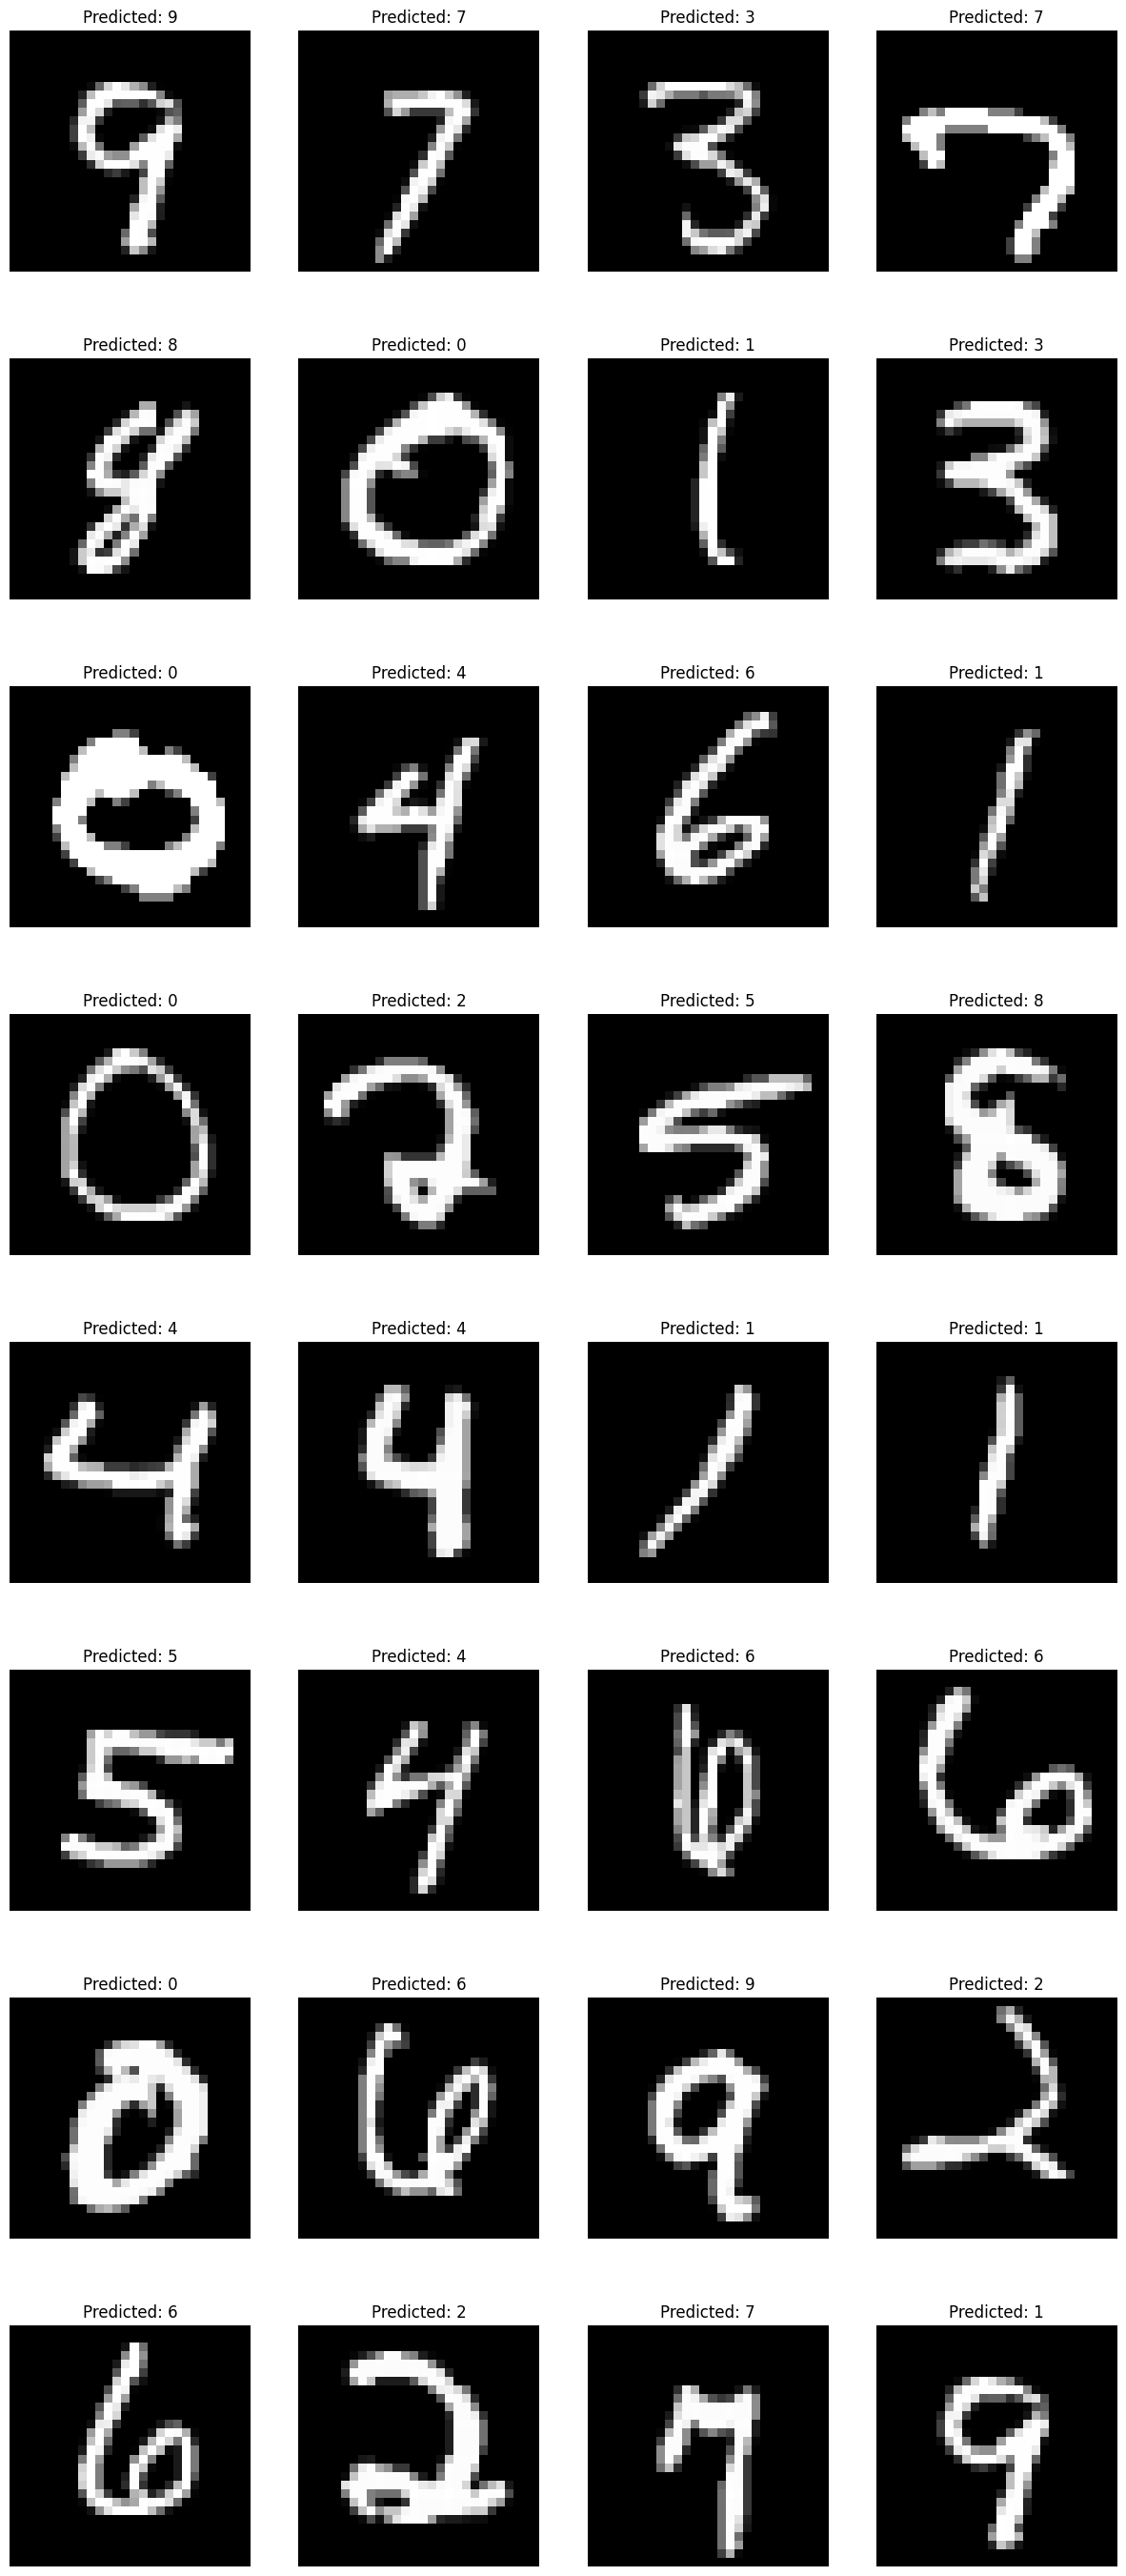

In [31]:
fig, ax = plt.subplots(8, 4, figsize=(15, 35))
batch_images, batch_true_labels = next(test_data_aug)
batch_predictions = model.predict(batch_images)
batch_true_indices = np.argmax(batch_true_labels, axis=1)
batch_pred_indices = np.argmax(batch_predictions, axis=1)

for i in range(32):
    ax[i // 4, i % 4].imshow(batch_images[i].squeeze(), cmap='gray')
    ax[i // 4, i % 4].axis('off')
    ax[i // 4, i % 4].set_title(f'Predicted: {batch_pred_indices[i]}')
#print('The batch's true indices are:')
print(batch_true_indices)
#print('The batch's predicted indices are:')
print(batch_pred_indices)
plt.imshow(batch_images[0].squeeze(), cmap='gray')